# SECTION 1: IMPORT PYTHON LIBRARIES AND DATASET

In [2]:
# install seaborn library
!pip install seaborn
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
# load the salary dataset
salary_df = pd.read_csv('salary-data.csv')

In [4]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsExperience  30 non-null     float64
 1   Salary           30 non-null     float64
dtypes: float64(2)
memory usage: 608.0 bytes


# SECTION 2: PERFORM DATA ANALYSIS AND DATA VISUALIZATION

<AxesSubplot:>

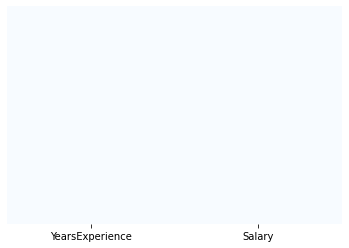

In [5]:
# Check if there is a null value in the dataset
sb.heatmap(salary_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [6]:
salary_df.shape

(30, 2)

In [7]:
salary_df.describe()

,YearsExperience,Salary
count,30.000000,30.000000
mean,5.313333,76003.000000
std,2.837888,27414.429785
min,1.100000,37731.000000
25%,3.200000,56720.750000
50%,4.700000,65237.000000
75%,7.700000,100544.750000
max,10.500000,122391.000000


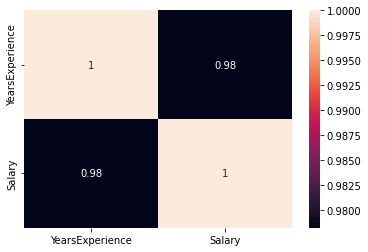

In [8]:
# Check the correlatio of the data
corr_matrix = salary_df.corr()
sb.heatmap(corr_matrix, annot = True)
plt.show()

<AxesSubplot:xlabel='YearsExperience', ylabel='Salary'>

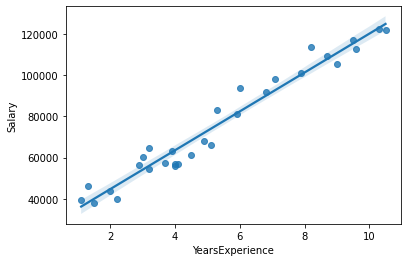

In [9]:
# Plot data and a linear regression model fit
sb.regplot(x = salary_df['YearsExperience'], y = salary_df['Salary'], data = salary_df)

# SECTION 3: CREATE TRAINING AND TESTING DATASET

In [ ]:
X = salary_df[['YearsExperience']]
y = salary_df[['Salary']]

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
# Set the datatype into float32
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [ ]:
X

In [ ]:
y

In [ ]:
# split the data into training and test sets
!pip install scikit-learn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# SECTION 4: TRAIN A LINEAR LEARNER MODEL USING SAGEMAKER

In [ ]:
# Boto3 is Amazon Web Services (AWS) Software Development kit (SDK) for Python 

import boto3
import sagemaker
from sagemaker import Session

# Let's create a SageMaker session
sagemaker_session = sagemaker.Session()

# Define the bucket and prefix that will be used for training purposes (Bucket has to be created in S3 manually)
# prefix is the subfolder is the S3 bucket
bucket = 'milad-sagemaker-linear-bucket'
prefix = 'linear-learner'

# Create the execution role for the instance to access/write in S3 bucket
sagemaker_role = sagemaker.get_execution_role()
print(sagemaker_role)

In [ ]:
X_train.shape

In [ ]:
# convert y_train into vector
y_train = y_train[:,0]

In [ ]:
y_train.shape

In [ ]:
# Required format for SageMaker is RecordIO, therefore the numpy array has to be converted into RecordIO format
# The code in this cell cis to  convert the data in numpy array format to RecordIO format in order to be send as input into SageMaker
# This is the format required by Sagemaker Linear Learner 

# IO is a module to deal with various typoes of I/O 
# sagemaker amazon common library 
import io
import sagemaker.amazon.common as smac

# create in-memory byte array for training set, write into it, reset the buffer after every write
buffer = io.BytesIO()
smac.write_numpy_to_dense_tensor(buffer, X_train, y_train)
buffer.seek(0)

In [ ]:
# RecordIO input must be stored in S3

import os

key = 'training-data'

# Upload the training data with RecordIO format in S3
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buffer)

# S3 location where the training sata has been saved
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print(s3_train_data)

In [ ]:
X_test.shape

In [ ]:
# convert y_test into vector
y_test = y_test[:,0]

In [ ]:
y_test.shape

In [ ]:
# create in-memory byte array for test set, write into it, reset the buffer after every write

import io

buffer = io.BytesIO()
smac.write_numpy_to_dense_tensor(buffer, X_test, y_test)
buffer.seek(0)

In [ ]:
import os

key = 'test-data'

# Upload the test data with RecordIO format in S3
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buffer)

# S3 location where the training sata has been saved
s3_test_data = 's3://{}/test/{}'.format(bucket, key)
print(s3_test_data)

In [ ]:
# create an output placeholder in S3 bucket to store the linear learner output
output_location = 's3://{}/{}'.format(bucket, prefix)

# print output location in S3
print('output location is {}'.format(output_location))

In [ ]:
# Load the built-in ML algorthm container of sagemaker 

from sagemaker import image_uris
sagemaker_container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)

In [ ]:
sagemaker_container

In [ ]:
# use_spot_instances, max_run, max_wait are the parameters that can be removed. They are added to train the model on spot instances instead of on demand instances.
# Using spot instances reduce the cost tremendously however spot instances can be claime d by AWS at any time and should not be used for critical tasks.
linear = sagemaker.estimator.Estimator(sagemaker_container,
                                       sagemaker_role,
                                       instance_count = 1,
                                       instance_type = 'ml.c4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session,
                                       use_spot_instances = True,
                                       max_run = 300,
                                       max_wait = 600)

linear.set_hyperparameters(feature_dim = 1,
                           predictor_type = 'regressor',
                           mini_batch_size = 5,
                           epochs = 50,
                           num_models = 32,
                           loss = 'absolute_loss')

linear.fit({'train': s3_train_data})

In [ ]:
# Deploy the model to provide end point
# After runnig this cell you have to wait until you see ! then the deployment is completed ------------!
linear_regressor = linear.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer

#linear_regressor.content_type = 'text/csv'
linear_regressor.serializer = sagemaker.serializers.CSVSerializer()
linear_regressor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [ ]:
result = linear_regressor.predict(X_test)

In [ ]:
result

In [ ]:
prediction = np.array([r['score'] for r in result['predictions']])

In [ ]:
plt.scatter(X_test, y_test, color = "gray")
plt.plot(X_test, prediction, color = "blue")
plt.title('Salary Vs. Years of experience')
plt.xlabel('Years of experience')
plt.ylabel('Salary')
plt.show()

# SECTION 5: DO NOT FORGET TO DELETE THE ENDPOINT. IT COSTS YOU WHEN IT IT UP AND RUNNING

In [ ]:
linear_regressor.delete_endpoint()